In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile
from utils import plot_psd, psd, read_iq, welch

### How to demodulate FM (example)
1. Input sampling rate 2.4 MHz (top frequency content- LPF to 120 kHz and decimate by 10.
2. Demodulate - calculate derivative of signal phase
  - use atan2 and diff
  - use atan derivative formula 
3. Scale the signal (float requires `[-1, 1]` for example).  
4. LPF to 24 kHz and decimate by 5.

### Notes
1. Looks like low SNR - like 15dB from Welch below? I had 40dB in my earlier experiments. Also lab 6 mentions 43.4 dB SNR for quantization noise like "this may seem low" lol.

In [2]:
def fm_demod_1(iq_samples):
  return np.angle(iq_samples[1:] * np.conj(iq_samples[:-1]))
  

def fm_demod_2(iq_samples):
  xq, xi = np.imag(iq_samples), np.real(iq_samples)
  d_xq, d_xi = np.diff(xq, prepend=xq[0]), np.diff(xi, prepend=xi[0])
  return (xi * d_xq - xq * d_xi) / (xq ** 2 + xi ** 2)


def demodulate(iq_samples, demod=fm_demod_1):
  dec_iq_samples = signal.decimate(iq_samples, 10)
  demod = demod(dec_iq_samples)
  demod_dec = signal.decimate(demod, 5)
  return demod_dec / np.abs(demod_dec).max()

In [3]:
iq_samples = read_iq('zlote_przeboje.iq')

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


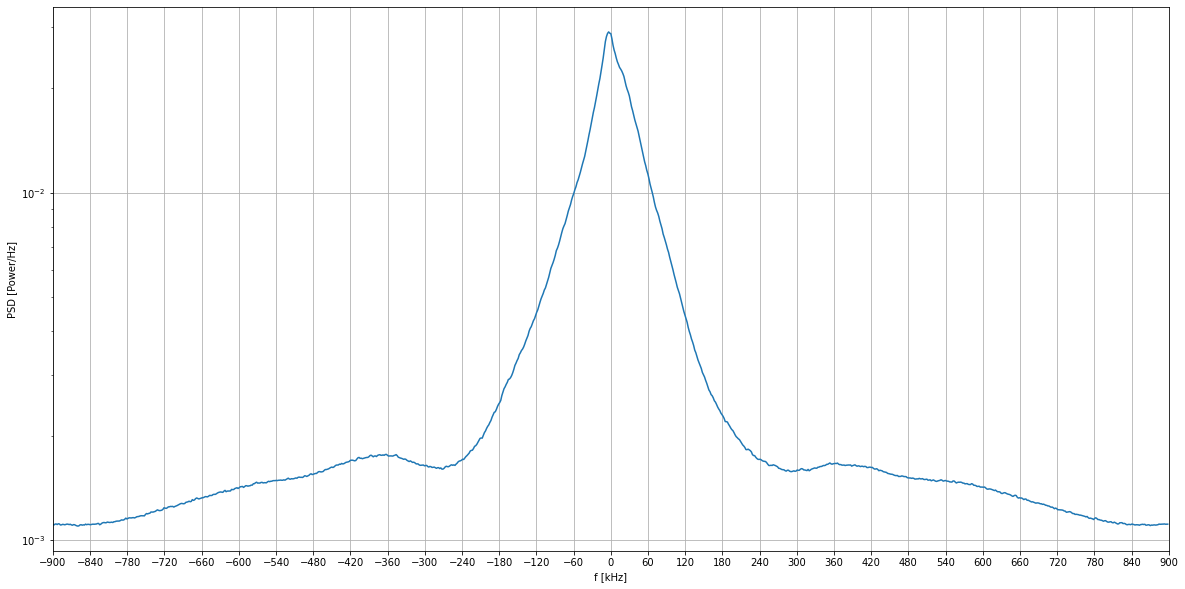

In [4]:
welch(iq_samples, 1800000)

In [10]:
from scipy.signal import decimate
dec_iq_samples = decimate(iq_samples, 6)

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


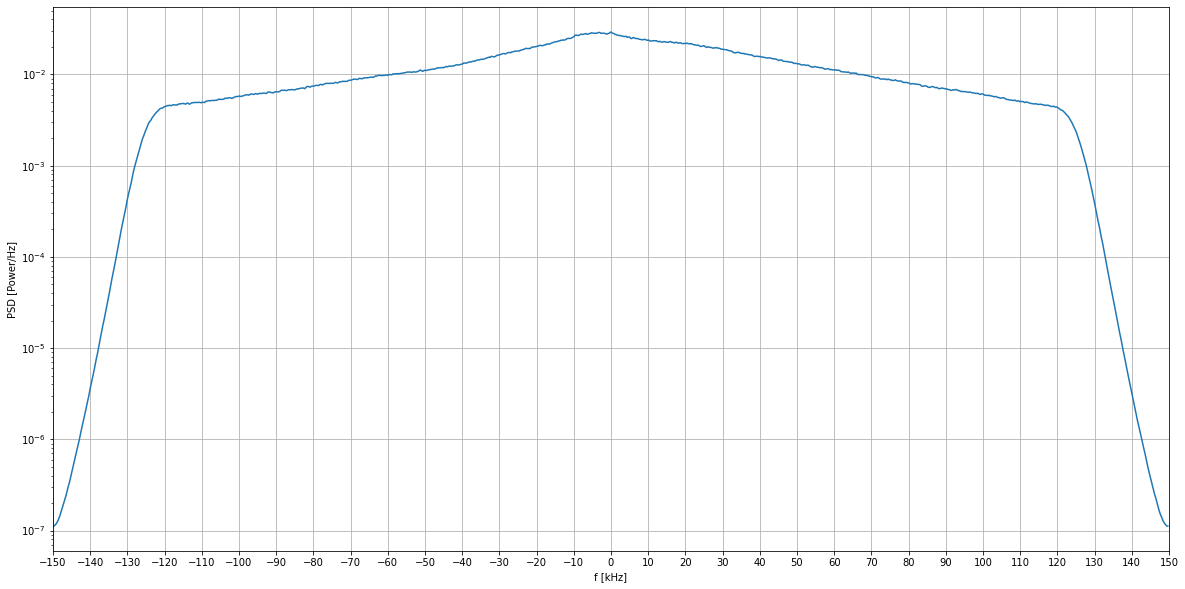

In [11]:
n_rate = 1800000 / 6
welch(dec_iq_samples, n_rate)

### Phase derivative (diff) with conjugate multiplication
Maybe avoids wrapping?

In [12]:
phase_diff = np.angle(dec_iq_samples[1:] * np.conj(dec_iq_samples[:-1]))

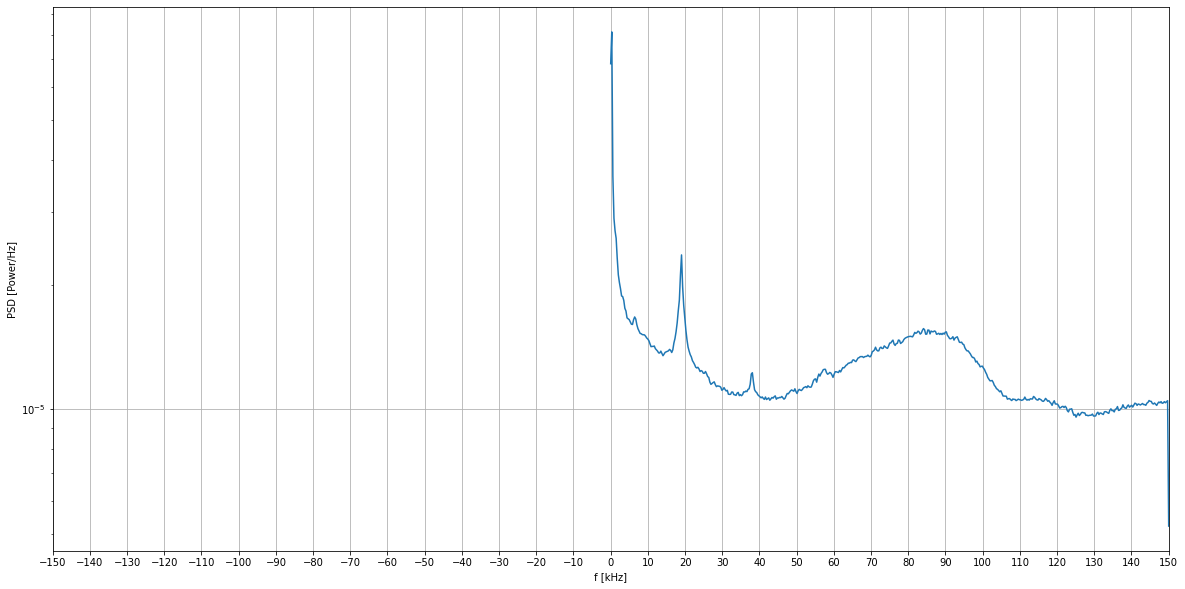

In [13]:
welch(phase_diff, n_rate) 

In [14]:
phase_diff_dec = decimate(phase_diff, 5)

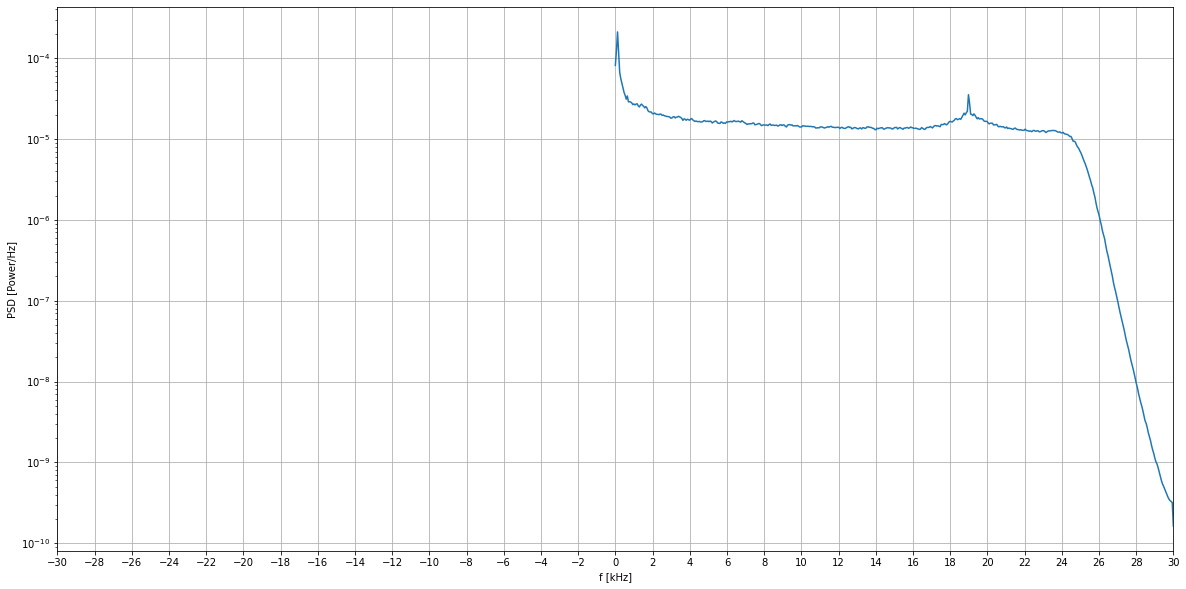

In [15]:
welch(phase_diff_dec, n_rate / 5) 

In [21]:
wavfile.write('farts.wav', 60000, phase_diff_dec / np.abs(phase_diff_dec).max())

So this is a success: play with `play -r 60k -e float -b 64 farts.wav` command. It seems (seen in Welch above too) that there is just very low signal level (very farty audio - but e.g. "wszystkich których" is intelligible), I wonder why.

### Phase derivative with $atan$ derivative formula

In [33]:
xq, xi = np.imag(dec_iq_samples), np.real(dec_iq_samples)
d_xq, d_xi = np.diff(xq, prepend=xq[0]), np.diff(xi, prepend=xi[0])
phase_diff2 = (xi * d_xq - xq * d_xi) / (xq ** 2 + xi ** 2)

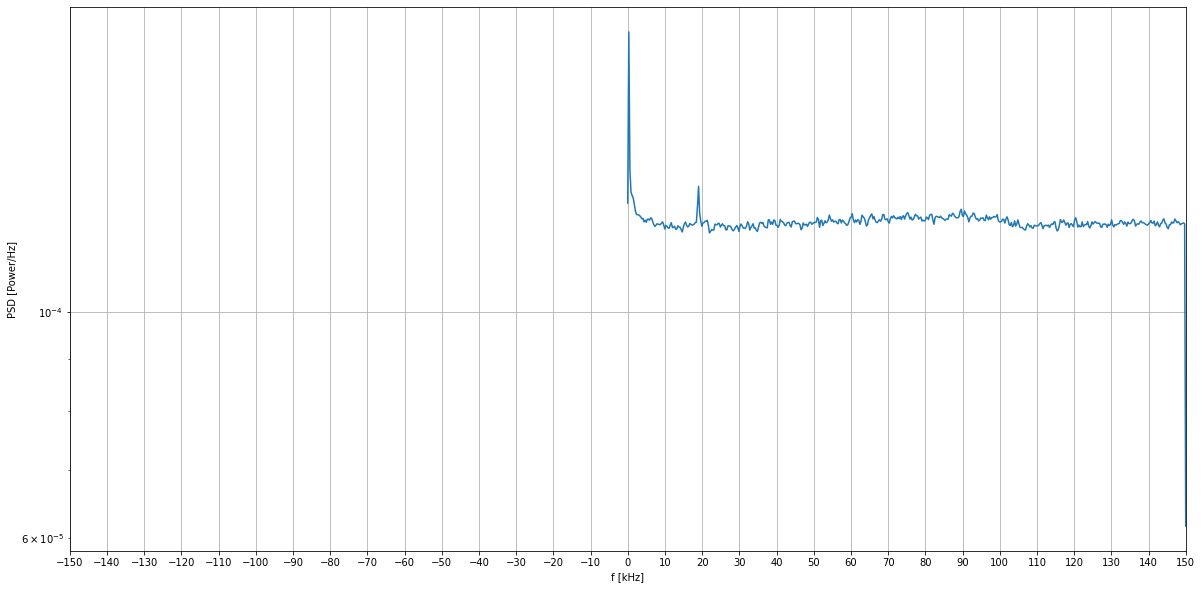

In [34]:
welch(phase_diff2, n_rate) 

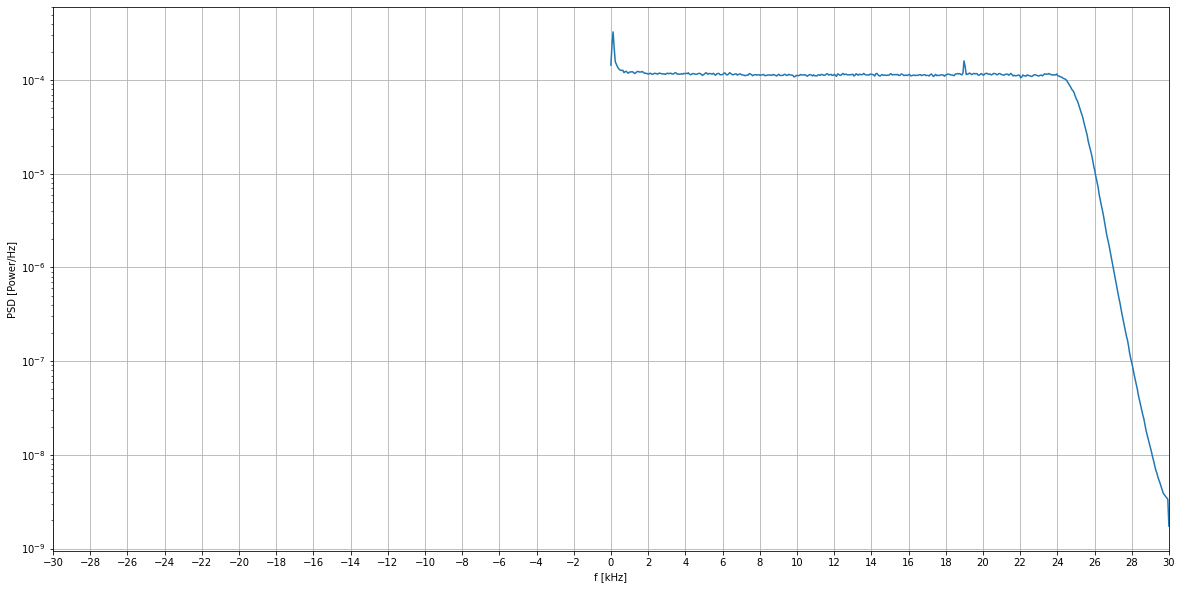

In [36]:
phase_diff2_dec = decimate(phase_diff2, 5)
welch(phase_diff2_dec, n_rate / 5)

In [37]:
wavfile.write('farts2.wav', 60000, phase_diff2_dec / np.abs(phase_diff2_dec).max())

This is just constant low-level hiss. So previous demodulation approach worked better!

### TODO
1. De-emphasis filter (attenuates high frequencies)?
2. Tune to other frequency and do frequency shift to avoid DC spike?
3. Check other samples for SNR. Other sampling rate?

In [8]:
iq_samples2 = read_iq('zlote_przeboje_2_4M_higher.iq')

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


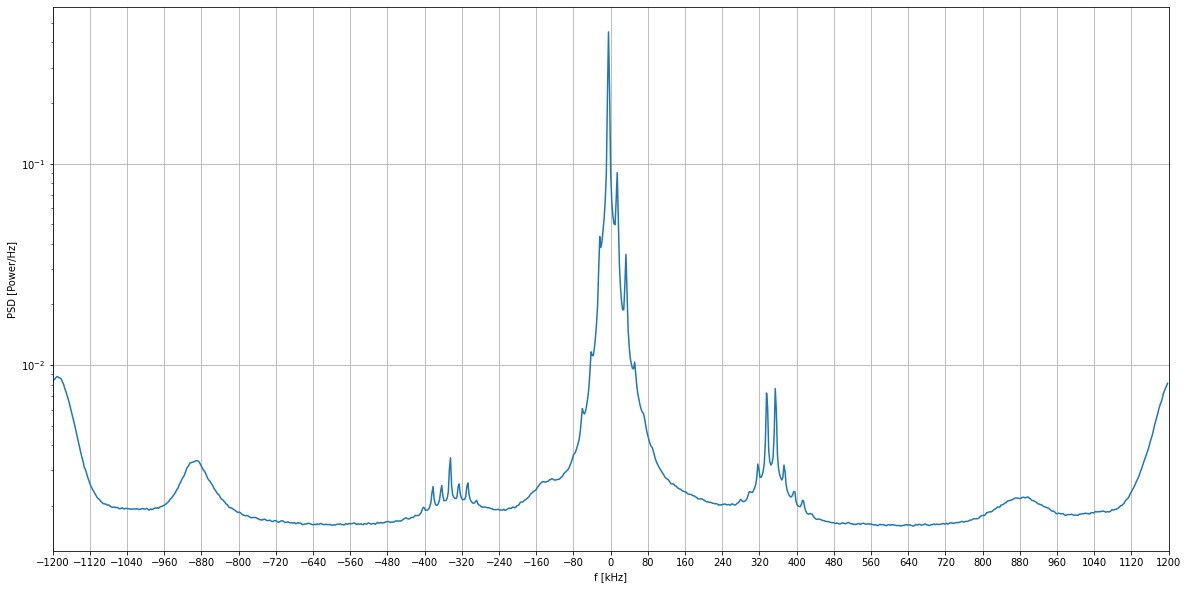

In [9]:
welch(iq_samples2, 2400000)

In [26]:
demod_result = demodulate(iq_samples2, demod=fm_demod_1)
wavfile.write('farts3.wav', 48000, demod_result)

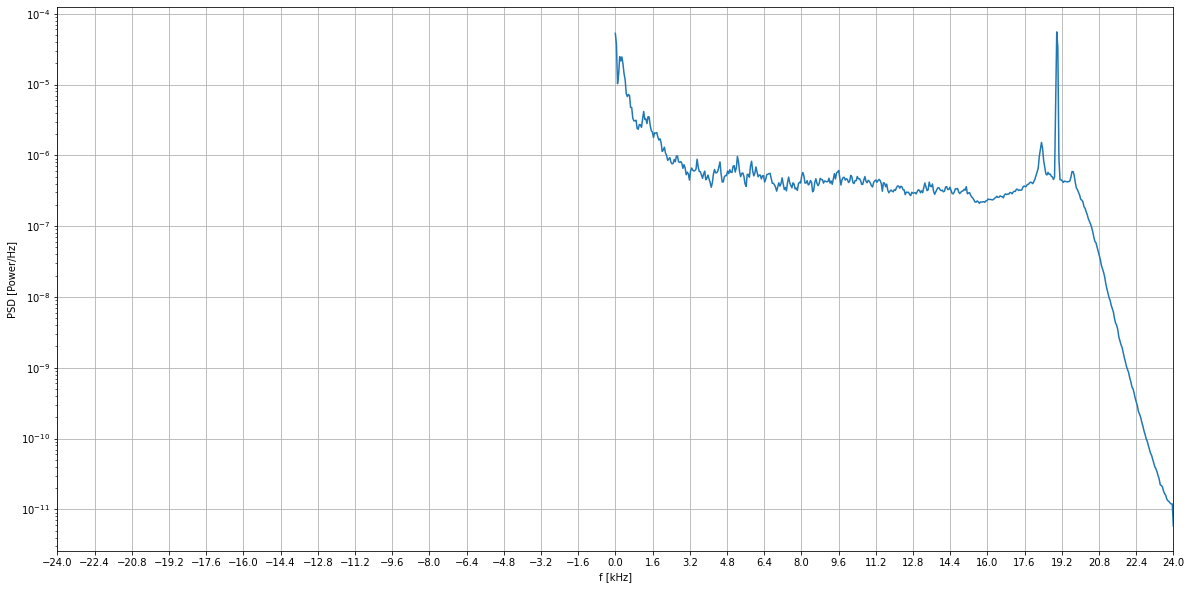

In [25]:
welch(demod_result, 48000)

**Ladies and gentlemen, this is Mambo no. 5**

 - WAY better quality - antenna closer to the window (sampling rate 2.4MHz - doesn't make difference?), apparently around 20dB SNR.
 - very interestingly, `fm_demod_2` algorithm produces similar hiss as before... Poor derivative approximation?

### Another attempt with default antenna setting
I'd like to know if `rtl_fm` really gets more out of weak signal (or was this 15dB SNR just some accident).

In [5]:
iq_samples3 = read_iq('zlote_przeboje_2_4M_default_again.iq')

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


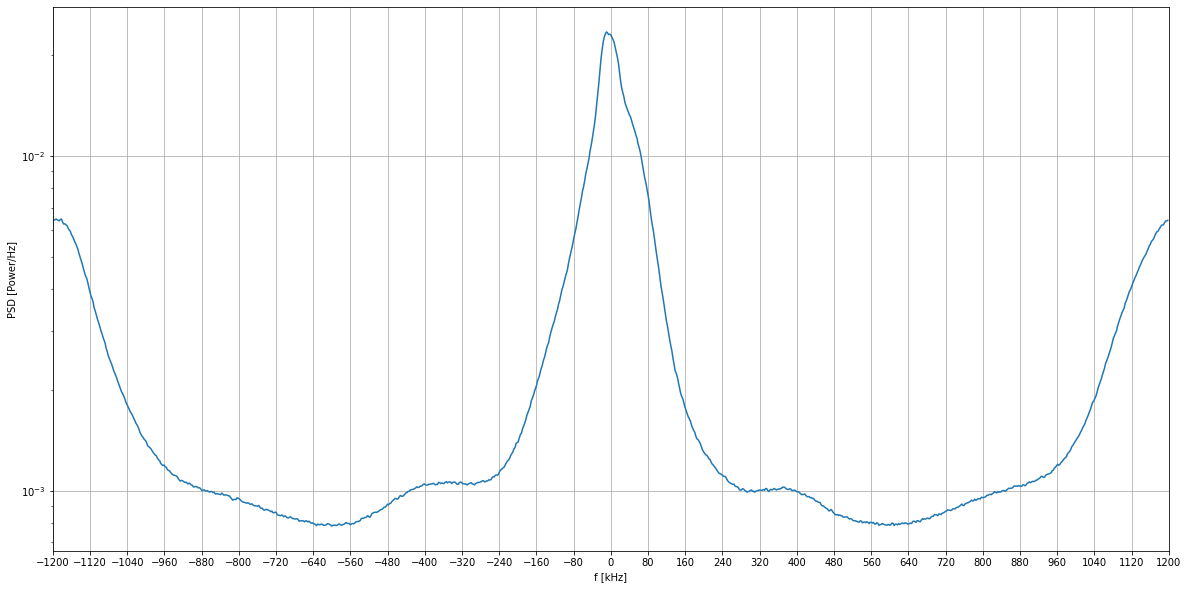

In [6]:
welch(iq_samples3, 2400000)

In [7]:
iq_samples4 = read_iq('zlote_przeboje_1_8M_default.iq')

/home/jlanecki/miniconda3/envs/sdr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


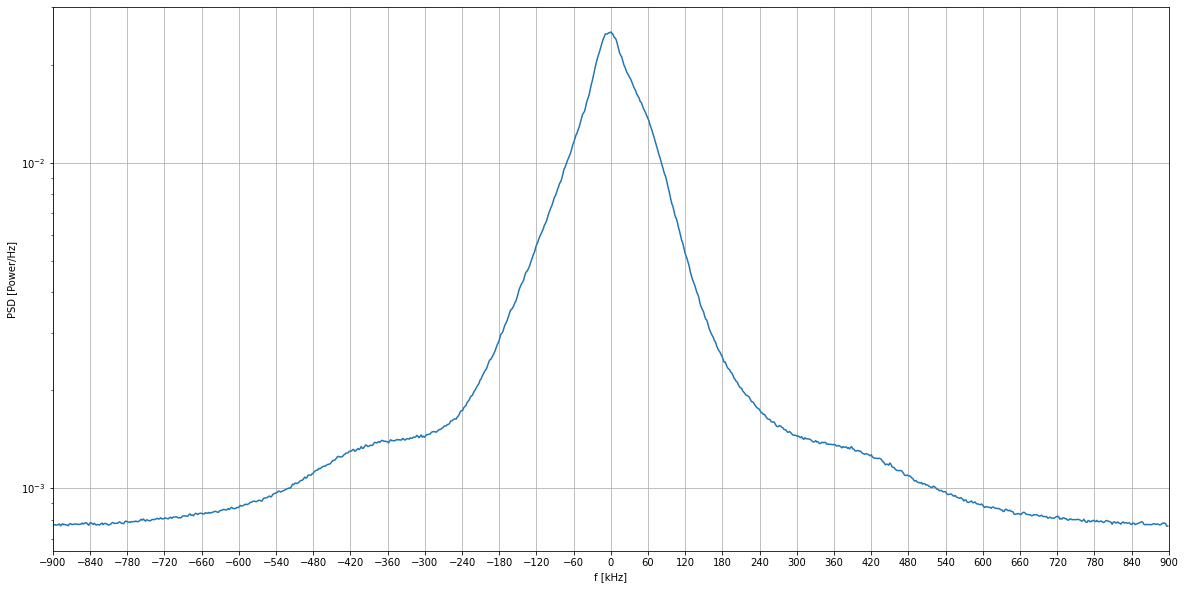

In [8]:
welch(iq_samples4, 1800000)

So not really any SNR difference w.r.t. sampling rate - as expected.

In [9]:
demod_result2 = demodulate(iq_samples3)
wavfile.write('farts4.wav', 48000, demod_result2)

Aaand this is farts again - SNR too low apparently.

At the same time `rtl_fm` **tuned to a different frequency** (92.755 kHz instead of 92.5 kHz):
```
In:0.00% 00:00:00.00 [00:00:00.00] Out:0     [      |      ]        Clip:0    Found Rafael Micro R820T tuner
Tuner gain set to automatic.
Tuned to 92755000 Hz.
Oversampling input by: 6x.
Oversampling output by: 1x.
Buffer size: 8.03ms
Exact sample rate is: 1020000.026345 Hz
Sampling at 1020000 S/s.
Output at 170000 Hz.

```

In [10]:
iq_samples4 = read_iq('zlote_przeboje_2_4M_default_freqshift.iq')

In [11]:
demod_result4 = demodulate(iq_samples4)
wavfile.write('farts5.wav', 48000, demod_result4)

Nope, off frequency by itself solves nothing (shift required? but `rtl_fm` doesn't do it?).